In [4]:
# 1. Import libraries
import pandas as pd
import numpy as np

# 2. Load data
file_path = r"C:\Users\up32n\reliance_forpowerbi_latest.csv"
df = pd.read_csv(file_path, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Compute trend & momentum indicators
df["SMA_50"] = df["adj_close"].rolling(50, min_periods=1).mean()
df["SMA_200"] = df["adj_close"].rolling(200, min_periods=1).mean()

df["EMA_12"] = df["adj_close"].ewm(span=12, adjust=False).mean()
df["EMA_26"] = df["adj_close"].ewm(span=26, adjust=False).mean()
df["MACD_Line"] = df["EMA_12"] - df["EMA_26"]
df["Signal_Line"] = df["MACD_Line"].ewm(span=9, adjust=False).mean()
df["MACD_Histogram"] = df["MACD_Line"] - df["Signal_Line"]

delta = df["Daily_Return_adj"]
gain = delta.clip(lower=0).rolling(14, min_periods=1).mean()
loss = (-delta.clip(upper=0)).rolling(14, min_periods=1).mean()
df["RSI_14"] = 100 - 100/(1 + gain.div(loss.replace(0, np.nan)))

# 4. Volume average
df["Vol_MA_20"] = df["volume"].rolling(20, min_periods=1).mean()

# 5. Initialize and flag demerger event
df["Demerger_Event"] = False
event_date = pd.Timestamp("2023-07-20")
window = 5
mask = (
    (df["Date"] >= event_date - pd.Timedelta(days=window*1.5)) &
    (df["Date"] <= event_date + pd.Timedelta(days=window*1.5))
)
df.loc[mask, "Demerger_Event"] = True

# 6. Compute event returns
pre_close = df.loc[df["Date"] == event_date - pd.Timedelta(days=1), "adj_close"]
on_close  = df.loc[df["Date"] == event_date, "adj_close"]
if not pre_close.empty and not on_close.empty:
    event_return = (on_close.iloc[0]/pre_close.iloc[0] - 1)*100
    print(f"Return on demerger date ({event_date.date()}): {event_return:.2f}%")
avg_return = df.loc[mask, "Daily_Return_adj"].mean()*100
print(f"Avg daily return ±{window} days: {avg_return:.2f}%")

# 7. Export for Power BI
output_path = r"C:\Users\up32n\reliance_with_indicators.csv"
df.to_csv(output_path, index=False)

# 8. Verify
print(df[[
    "Date","adj_close","SMA_50","SMA_200",
    "RSI_14","MACD_Line","Signal_Line","MACD_Histogram",
    "Vol_MA_20","Demerger_Event"
]].head(10))


Return on demerger date (2023-07-20): -0.12%
Avg daily return ±5 days: -17.60%
        Date  adj_close    SMA_50   SMA_200     RSI_14  MACD_Line  \
0 1996-01-01   9.302441  9.302441  9.302441        NaN   0.000000   
1 1996-01-02   9.230103  9.266272  9.266272   0.000000  -0.005770   
2 1996-01-03   9.300181  9.277575  9.277575  49.401932  -0.004636   
3 1996-01-04   9.214280  9.261751  9.261751  30.856839  -0.010546   
4 1996-01-05   9.150982  9.239598  9.239598  24.122083  -0.020106   
5 1996-01-08   8.784761  9.163791  9.163791  10.619466  -0.056581   
6 1996-01-09   8.531570  9.073474  9.073474   7.568405  -0.104711   
7 1996-01-10   8.312292  8.978326  8.978326   6.024792  -0.158719   
8 1996-01-11   8.572263  8.933208  8.933208  24.710360  -0.178485   
9 1996-01-12   8.481839  8.888071  8.888071  23.157382  -0.199151   

   Signal_Line  MACD_Histogram     Vol_MA_20  Demerger_Event  
0     0.000000        0.000000  5.206068e+07           False  
1    -0.001154       -0.004616  6.8

In [5]:
import numpy as np

# Total return over period
total_return = (df["adj_close"].iloc[-1] / df["adj_close"].iloc[0] - 1) * 100

# Annualized volatility (std of daily returns × √252)
volatility = df["Daily_Return_adj"].std() * np.sqrt(252) * 100

# Maximum drawdown
cum_max = df["adj_close"].cummax()
drawdown = (cum_max - df["adj_close"]) / cum_max
max_drawdown = drawdown.max() * 100

print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Volatility: {volatility:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")


Total Return: 31369.16%
Annualized Volatility: 4728.89%
Max Drawdown: 72.37%


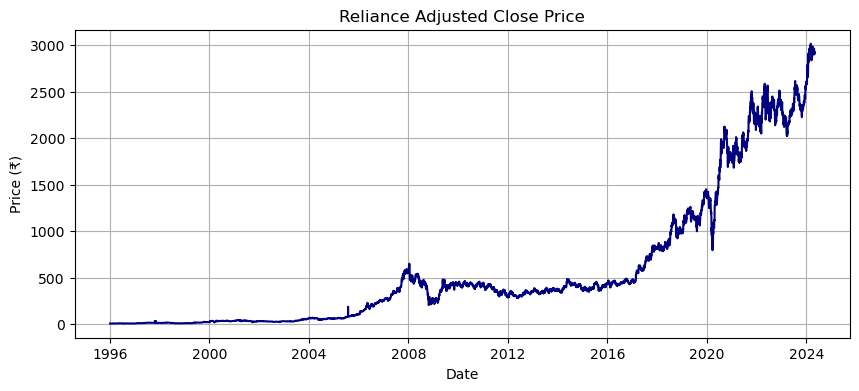

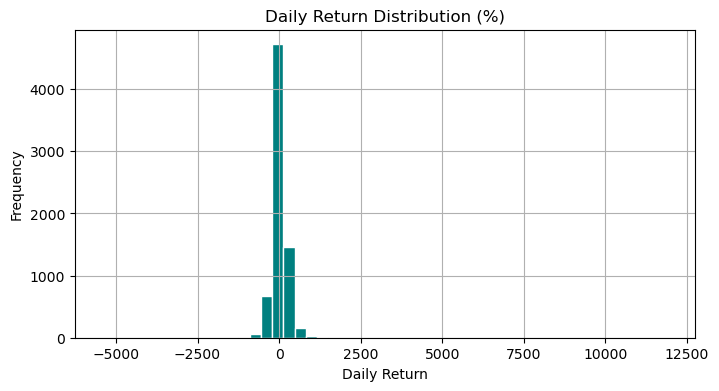

In [6]:
import matplotlib.pyplot as plt

# Price time series
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["adj_close"], color="navy")
plt.title("Reliance Adjusted Close Price")
plt.xlabel("Date"); plt.ylabel("Price (₹)")
plt.grid(True); plt.show()

# Histogram of daily returns
plt.figure(figsize=(8,4))
plt.hist(df["Daily_Return_adj"]*100, bins=50, color="teal", edgecolor="white")
plt.title("Daily Return Distribution (%)")
plt.xlabel("Daily Return"); plt.ylabel("Frequency")
plt.grid(True); plt.show()
